In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(0, '/home/fbuonerba/codes/')
from mp_functions import upload_log_return, upload_factor_loadings
from coinapi_v1 import CoinAPIv1
import datetime
from datetime import datetime, timedelta
import time
import calendar
import json
import urllib.request
import multiprocessing as mp
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('/home/fbuonerba/codes/meta_data/new_coins.txt') as ff:
    coins=json.load(ff)
bad=['NPXS','MKR','VET','RHOC', 'ONT', 'ZIL', 'NANO', 'BAT','BCD','XTZ']
coins=np.array(coins)
where=[i for i in range(len(coins)) if coins[i] in bad]
coins=np.delete(coins, where)

prettybad=['BCN','DCR','BTG','BTM','XVG']
prettywhere=[i for i in range(len(coins)) if coins[i] in prettybad]
coins=np.delete(coins, prettywhere)
quotes=['BTC']
print(coins)

['BTC' 'ETH' 'XRP' 'BCH' 'EOS' 'XLM' 'LTC' 'ADA' 'XMR' 'IOTA' 'TRX' 'ETC'
 'DASH' 'NEO' 'XEM' 'BNB' 'ZEC' 'OMG' 'LSK' 'ZRX' 'QTUM' 'DOGE' 'BTS'
 'DGB' 'ICX' 'STEEM' 'AE' 'WAVES' 'SC' 'REP' 'PPT' 'GNT' 'STRAT']


In [3]:

#sysm=[str(coin)+'_'+str(quote) for coin in coins for quote in quotes]
def get_returns(beg,end):
    #weights=0 or 1
    t=beg
    matrix=[]
    while t<=end+1:
        ret_t=[]
        for base in coins:
            for quote in quotes:
                returns=upload_log_return(t, base, quote, 86400)
                if np.isnan(returns)==True:
                    #print(base, 'bad boy')
                    returns=0
                ret_t.append(returns)
                #print(base,quote)
        matrix.append(ret_t)
        t+=86400
    R=np.array(matrix)
    norms=np.linalg.norm(R, axis=0)
    W=np.where(norms==0)
    ##careful here: W might change over different times!
    ######
    R=np.delete(R, W, axis=1) 
    #std=np.std(R, axis=0)
    #return degenerate_indices, returns
    return(W, R)

#####W[0]=those pairs for which no trading activity is recorded
#VET,NPXS have no data for this time period. Indeed they were ranked low on cmc.
#then BTC has no data vs BTC, the rest have no data vs USD.


In [4]:
#####Factors: January to April#####
#####log_mkcap and coin_ratio computed averaging.
#####Those are the good ones!

########removing coin ratio to see what happens!!

factors=[]
keys=['returns_variance', 'returns_strength', 'rates_high_low','turnover', 'log_marketcap']#,'coin_ratio']
naive_folder='/home/fbuonerba/factor_loadings/naive_factors_'
#folder='/home/fbuonerba/factor_loadings/averaged_factors_'
exact_folder='/home/fbuonerba/factor_loadings/exact_factors_'
def get_raw_factors(beg,end,W,index='averaged'):
    folder='/home/fbuonerba/factor_loadings/averaged_factors_'
    if index=='exact':
        folder=exact_folder
    elif index=='naive':
        folder=naive_folder
    factors=[]
    std=[]
    for coin in coins:
        for quote in quotes:
            with open(folder+coin+'_'+quote+'_'+str(beg)+'_'+str(end)+'_86400.txt') as data:
                fac=json.load(data)
            ordr=[]
            for key in keys:
                if key=='returns_variance':
                    E=fac[key]**.5
                    std.append(E)
                else:
                    E=fac[key]
                ordr.append(E)
            factors.append(ordr)
    factors=np.array(factors)
    std=np.array(std)
    factors=np.delete(factors, W, axis=0)
    std=np.delete(std, W, axis=0)
    std=std.reshape(-1,1)
    #####here we do normalization using z-score along coin axis#####
    factors[np.where(np.isnan(factors)==True)]=0
    
    ###There are two NaN entries, corresponding to coin ratio of BCD, 43rd position.
    ###In a random cmc_historical, the supply is nan. Confirmed on cmc website chart:
    #at the time BCD was doing poorly - in march it was ranked 1250th.
    return(std, factors)

def get_processed_factors(beg,end,W, index=None):
    std, factors=get_raw_factors(beg,end,W, index)
    factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5
    return(std, factors)


In [ ]:
#####Factors: January to April#####
#####log_mkcap and coin_ratio computed on the day.
factors=[]
new_keys=['returns_variance', 'returns_strength', 'rates_high_low','turnover']
exact_keys=['log_mkcap_exact_','coin_ratio_exact_']
new_folder='/home/fbuonerba/factor_loadings/naive_factors_'
folder='/home/fbuonerba/factor_loadings/factors_'
exact_folder='/home/fbuonerba/factor_loadings/exact_factors'
def get_raw_barra_factors(beg,end,W):
    factors=[]
    std=[]
    for coin in coins:
        for quote in quotes:
            with open(folder+coin+'_'+quote+'_'+str(beg)+'_'+str(end)+'_86400.txt') as data:
                fac=json.load(data)
            ordr=[]
            for key in new_keys:
                if key=='returns_variance':
                    E=fac[key]**.5
                    std.append(E)
                else:
                    E=fac[key]
                ordr.append(E)
            ####exact factors####
            with open(exact_folder+exact_keys[0]+coin+'_'+quote+'_'+str(end)+'.txt') as ff:
                exc=json.load(ff)
            ordr.append(exc)
            with open(exact_folder+exact_keys[1]+coin+'_'+str(end)+'.txt') as ff:
                exc=json.load(ff)
            ordr.append(exc)
            factors.append(ordr)
    factors=np.array(factors)
    std=np.array(std)
    factors=np.delete(factors, W, axis=0)
    std=np.delete(std, W, axis=0)
    std=std.reshape(1,-1)
    factors[np.where(np.isnan(factors)==True)]=0
    return(std, factors)
    ###There are two NaN entries, corresponding to coin ratio of BCD, 43rd position.
    ###In a random cmc_historical, the supply is nan. Confirmed on cmc website chart:
    #at the time BCD was doing poorly - in march it was ranked 1250th.
def get_processed_barra_factors(beg,end,W):
    std, factors=get_raw_barra_factors(beg,end,W)
    factors=(factors-np.mean(factors,axis=0))/np.var(factors,axis=0)**.5
    return(std, factors)

In [5]:
import statsmodels.api as sm
import cvxopt
from cvxopt import matrix, solvers
from cvxopt.blas import dot
from cvxopt.solvers import qp

solvers.options['show_progress'] = False
def fit_model(day):
    W, returns=get_returns(day, day)
    returns=np.array(returns[0])
    std, factors=get_processed_factors(day-(1522540800-1515283200),day, W)
    factors=sm.add_constant(factors)
    wt=1/std**2
    wls=sm.WLS(returns, factors, weights=wt).fit()
    return(returns, factors, std, wls)
    

def corr(day):
    returns, factors, std, wls=fit_model(day)
    beta=wls.params
    residual=returns-wls.predict()
    cor=np.dot( np.dot(factors, np.cov(beta.T)), factors.T) + np.diag(residual**2)
    #diag=np.diag(  std.reshape(1,-1)[0]**2    )
    #cor=np.dot( np.dot(factors, np.cov(beta.T)), factors.T) + diag
    return(cor)

def raw_corr(day):  
    day0=day-(1522540800-1515283200)
    RET=[]
    while day0<day:
        W, ret = get_returns(day0, day0)
        RET.append(ret[0])
        day0+=86400
    RET=np.array(RET).T
    cor=np.corrcoef(RET)
    return(cor)

def portfolio(day, alpha, method=None, mu=1):
    cor=corr(day)
    if method=='raw':
        cor=raw_corr(day)
    num=cor.shape[0]
    a=matrix(alpha)
    S=matrix(cor)
    G=-matrix(np.eye(32))#forcing every weight positive
    #G = matrix(0.0, (num,num))#these G,h do nothing but must be here.
    
    #G[::n+1] = -1.0 #this makes G=-id and creates inequality constraint.
    h = matrix(0.0, (num,1))
    A = matrix(1.0, (1,num))
    b = matrix(1.0)
    sol=np.array(qp(mu*S, -a, G, h, A, b)['x'])#solve -mu x.S.x + p_bar.x under Gx<=h, Ax=b
    
    ret=get_returns(day,day)[1][0]
    realized_return=np.dot(ret, sol)
    
    return(sol, realized_return)


In [6]:
def sharpe_ratio(alpha, day_init, day_end, method='None'):
    days= int((day_end-day_init)/86400)
    returns=[]
    for t in range(days):
        returns.append(portfolio(day_init+t*86400, alpha, method)[1])
    returns=np.array(returns)
    sharpe_ratio=np.mean(returns)/np.std(returns)
    return(sharpe_ratio)
        
    

In [8]:
day=1522540800
day_end=day + 140*86400
alpha=np.zeros(32)
for i in range(1,10):
    alpha[:i]=1
    alpha/=np.sum(alpha)
    opt_sharpe=sharpe_ratio(alpha, day, day_end)
    raw_sharpe=sharpe_ratio(alpha, day, day_end,'raw')
    print(opt_sharpe, raw_sharpe)

-0.05968470272685436 -0.059337622961382536
-0.07847954381513018 -0.0604569905307626
-0.1152562900833619 -0.045951947397474234
-0.09523852101681866 -0.03304310569729318
-0.12666153396390298 -0.01636139636315351
-0.1396780847483446 -0.043006311314621154
-0.17746843215054886 -0.04388404928561527
-0.1826443755356652 -0.06277305749404026
-0.18358669976473657 -0.07101226324859544


In [63]:
day=1522540800
r2=[]
beta=[]
inter=[]
for t in range(140):
    wls=fit_model(day+86400*t)[3]
    print(wls.params)
    print(wls.summary())
    
    r2.append(wls.rsquared)
    beta.append(wls.params)

[-0.02522304  0.00554877 -0.01124531 -0.01984839 -0.00410996 -0.00034413]
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.193
Model:                            WLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.241
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.319
Time:                        20:33:27   Log-Likelihood:                 74.313
No. Observations:                  32   AIC:                            -136.6
Df Residuals:                      26   BIC:                            -127.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            WLS   Adj. R-squared:                 -0.094
Method:                 Least Squares   F-statistic:                    0.4676
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.797
Time:                        20:33:27   Log-Likelihood:                 50.329
No. Observations:                  32   AIC:                            -88.66
Df Residuals:                      26   BIC:                            -79.86
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.012      1.405      0.1

[ 0.02336146  0.0101086   0.00894797 -0.01263076 -0.00448612 -0.00616963]
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            WLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.301
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.294
Time:                        20:33:27   Log-Likelihood:                 62.294
No. Observations:                  32   AIC:                            -112.6
Df Residuals:                      26   BIC:                            -103.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

[ 0.02542967  0.00714419  0.01377694 -0.01573614 -0.00489008 -0.01053534]
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            WLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9761
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.451
Time:                        20:33:27   Log-Likelihood:                 59.010
No. Observations:                  32   AIC:                            -106.0
Df Residuals:                      26   BIC:                            -97.23
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

[ 0.00994444 -0.01158514 -0.01063823  0.01721172  0.00029312  0.00557444]
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            WLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.032
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.420
Time:                        20:33:28   Log-Likelihood:                 73.667
No. Observations:                  32   AIC:                            -135.3
Df Residuals:                      26   BIC:                            -126.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            WLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     2.824
Date:                Thu, 25 Oct 2018   Prob (F-statistic):             0.0363
Time:                        20:33:28   Log-Likelihood:                 86.283
No. Observations:                  32   AIC:                            -160.6
Df Residuals:                      26   BIC:                            -151.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.003     -2.414      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            WLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.6383
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.672
Time:                        20:33:28   Log-Likelihood:                 72.495
No. Observations:                  32   AIC:                            -133.0
Df Residuals:                      26   BIC:                            -124.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.005      2.298      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.600
Model:                            WLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     7.807
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           0.000135
Time:                        20:33:28   Log-Likelihood:                 78.859
No. Observations:                  32   AIC:                            -145.7
Df Residuals:                      26   BIC:                            -136.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0265      0.004     -6.011      0.0

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            WLS   Adj. R-squared:                 -0.127
Method:                 Least Squares   F-statistic:                    0.3009
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.908
Time:                        20:33:28   Log-Likelihood:                 76.265
No. Observations:                  32   AIC:                            -140.5
Df Residuals:                      26   BIC:                            -131.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0193      0.005      4.091      0.0

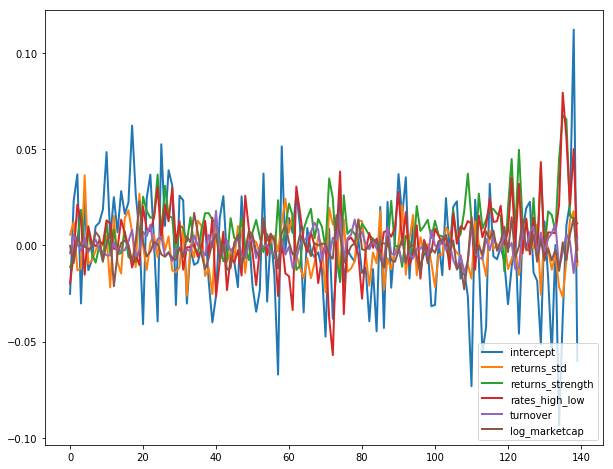

In [72]:
keyss=['intercept','returns_std', 'returns_strength', 'rates_high_low','turnover', 'log_marketcap',]
x=range(140)
fig, ax = plt.subplots(figsize=(10,8))
#line1, = ax.plot(x, np.sin(x), '--', linewidth=2,
                 #label='Dashes set retroactively')
#line1.set_dashes(dashes)
for i in range(6):
    ax.plot(x,betaT[i], linewidth=2, label=keyss[i])
ax.legend(loc='lower right')    #plt.show()
plt.savefig('factor_loadings')

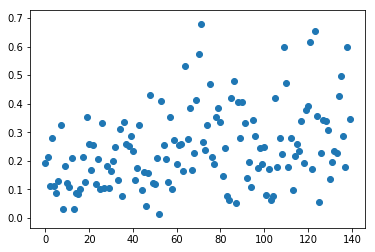

In [17]:
plt.scatter(range(140), r2)
plt.savefig('r2_scatter.png')

In [14]:
####Junk essentially####

# day=1522540800
# alpha=np.zeros(32)
# alpha[0]=1
# for i in range(1,10):
#     alpha[:i]=1
#     sharpe_ratios=[]#our model
#     sharpe_ratios_raw=[]
#     sharpe_ratios_alpha=[]
#     for t in range(140):
#         day_t=day+86400*t
#         #get correlations
#         cor=corr(day_t)
#         raw_cor=raw_corr(day_t)
#         #get portfolio weights and realized returns
#         weights, returns= portfolio(day_t, alpha)
#         weights_raw, returns_raw = portfolio(day_t, alpha, method='raw')
#         alpha_return=np.dot(get_returns(day_t,day_t)[1], alpha)

#         sharpe_ratios.append(sharpe_ratio(weights, returns, cor))
#         sharpe_ratios_raw.append(sharpe_ratio(weights_raw, returns_raw, raw_cor))
#         sharpe_ratios_alpha.append(sharpe_ratio(alpha.reshape(-1,1), alpha_return , cor))
        
#         sharpe=np.array([sharpe_ratios, sharpe_ratios_raw, sharpe_ratios_alpha])
#         maxim=np.argmax(sharpe, axis=0)
#         model=(maxim==0).sum()
#         raw=(maxim==1).sum()
#         alphaa=(maxim==2).sum()
#     print(model, raw, alphaa)
    

In [ ]:
day=1522540800
alpha=np.zeros(32)
alpha[0]=1
RET=[]
RET_raw=[]
for i in range(1,10):
    alpha[:i]=1
    for t in range(140):
        RET.append(portfolio(day+t*86400, alpha)[1])
        RET_raw.append(portfolio(day+t*86400, alpha,'raw')[1])
        


In [ ]:
X=np.array(RET)-np.array(RET_raw)
us=0
them=0
for x in X:
    if x>0:
        us+=1
    else:
        them+=1
print(us, them)

In [ ]:
import statsmodels.api as sm
#stats for log_returns in terms of BTC
methods=['averaged','barra']
weights=[0,1]
T=list(range(20))
beg=[1522540800+t*604800 for t in T]
end=[1522540800+(t+1)*604800 for t in T]
beg1=[1515283200+t*604800 for t in T]
end1=[1522540800+t*604800 for t in T]
###statsmodels works if do one regression per day, i.e. y a vector###
ret=[]
errors=[]
predictions=[]
factor_loadings=[]
victory=0
victory1=0
victory2=0
rsquares=[]
print('r2_naive', 'r2_exact', 'r2_averaged')
for j in range(len(T)):
    W,R=get_returns(beg[j],end[j])
    print(W)
    sys.stdout.flush()
    std, factors=get_processed_factors(beg1[j],end1[j],W, 'naive')
    std, factors1=get_processed_factors(beg1[j],end1[j],W,'exact')
    std, factors2=get_processed_factors(beg1[j],end1[j],W,'averaged')
    print('**********')
    sys.stdout.flush()
    X=factors
    X1=factors1
    X2=factors2
    X = sm.add_constant(X)
    X1 = sm.add_constant(X1)
    X2 = sm.add_constant(X2)
    for i in range(7):
        Y=R[i].T
        ret.append(Y)
        #est_nowt=sm.WLS(Y,X).fit()
        sss=1/std**2
        est_wt=sm.WLS(Y,X, weights=sss).fit()
        est_wt1=sm.WLS(Y,X1, weights=sss).fit()
        est_wt2=sm.WLS(Y,X2, weights=sss).fit()
        beta2=est_wt2.params
        factor_loadings.append(beta2)
        Y_hat=est_wt2.predict()
        error=est_wt2.predict()-Y
        predictions.append(Y_hat)
        errors.append(error)
    #look for heteroskedasticity!
    #plt.scatter(est_nowt.predict(),error)
    #plt.scatter(est_wt.predict(), error)
    #plt.show()
    #print(est_wt.summary())
        r2=est_wt.rsquared
        r21=est_wt1.rsquared
        r22=est_wt2.rsquared
        rsquares.append(r22)
        #print(r2, r21, r22)
        argm=np.argmax(np.array([r21, r22]))
        if argm==0:
            victory+=1
        elif argm==1:
            victory1+=1
        else:
            victory2+=1
print(victory, victory1, victory2)
    
#print('times naive won:', victory, 'times barra won', victory1)
    
        
#    #check errors are independent of factors!
#     for k in range(X.shape[1]):
#         if k>0:
#             print(keys[k-1])
#         plt.scatter(range(len(X.T[k])),X.T[k])#, error)
#         plt.show()

####check that errors are more or less iid by plotting covariance matrix####

rsquares=np.array(rsquares)
print(rsquares)
print(np.min(rsquares), np.max(rsquares), np.mean(rsquares))

In [ ]:
# X2 in memory is factor loadings at final time - we can use that
import statsmodels
predictions=np.array(predictions)
errors=np.array(errors)
ret=np.array(ret)
factor_loadings=np.array(factor_loadings)
factor_cov=np.cov(factor_loadings.T)
#factor_cov.shape
est_covariance=np.dot( np.dot(X2, np.cov(factor_loadings.T)), X2.T) 
delta=np.var(errors, axis=0)
est_covariance+=np.diag(delta)
raw_corr=np.corrcoef(ret.T)
raw_est_corr=np.corrcoef(predictions.T)
est_corr=statsmodels.stats.moment_helpers.cov2corr(est_covariance)
print('first plots Corr(raw_returns), second plots Corr(predicted_returns), \
third plots Factors.Corr(beta).Factors^T + Diag(err^2) ')
#print(raw_corr.shape, raw_est_corr.shape, est_corr.shape)
#heatmap of raw correlation
sns.set()
fig, ax = plt.subplots(figsize=(20,20))
ZZZ=sns.heatmap(raw_corr[:15,:15], annot = True, linewidths=1.5, ax=ax,xticklabels=coins[:15], yticklabels=coins[:15])
#ZZZ.figure.savefig("raw_corr.png")
#heatmap of raw correlation

sns.set()
fig, ax = plt.subplots(figsize=(20,20))
ZZZ=sns.heatmap(raw_est_corr[:15,:15], annot = True, linewidths=1.5, ax=ax,xticklabels=coins[:15], yticklabels=coins[:15])
#ZZZ.figure.savefig("raw_estimated_corr.png")
#heatmap of estimated correlation
sns.set()
fig, ax = plt.subplots(figsize=(20,20))
ZZZ=sns.heatmap(est_corr[:15,:15], annot = True, linewidths=1.5, ax=ax,xticklabels=coins[:15], yticklabels=coins[:15])
#ZZZ.figure.savefig("model_corr.png")

In [ ]:
corr_difference=est_corr-raw_corr
corr_difference
sns.set()
fig, ax = plt.subplots(figsize=(20,20))
ZZZ=sns.heatmap(corr_difference[:15,:15], vmin=-0.00001, vmax=0.00001, annot = True, linewidths=1.5, ax=ax,xticklabels=coins[:15], yticklabels=coins[:15])
ax.set_title('model_estimated_correlations - raw_correlations')
ZZZ.figure.savefig("correlation_difference.png")

In [ ]:
ret_tomorrow=ret[1:]
ret_today=ret[:-1]
err_tomorrow=errors[1:]
err_today=errors[:-1]
serial_ret_corr=np.corrcoef(ret_tomorrow.T , ret_today.T)[:32,32:].diagonal()
serial_error_corr=np.corrcoef(err_tomorrow.T , err_today.T)[:32,32:].diagonal()
ser_ret_m=np.mean(serial_ret_corr)
ser_ret_std=np.std(serial_ret_corr)
ser_err_m=np.mean(serial_error_corr)
ser_err_std=np.std(serial_error_corr)
print('mean and std for serial return correlations')
print(ser_ret_m, ser_ret_std)
print('mean and std for serial residual correlations')
print(ser_err_m, ser_err_std)
#plt.xlim(-1e-3,1e-3)
#plt.ylim(-1e-3,1e-3)
plt.ylabel('serial error corr')
plt.xlabel('serial return corr')
plt.xticks(rotation=90)
plt.scatter(serial_ret_corr,serial_error_corr)
# plt.savefig("serial_correlations.png")

In [ ]:
#same as above.
ser_corr_ret=[]
ser_corr_err=[]
for c in range(32):
    ser_corr_ret.append(np.corrcoef(ret.T[c][1:], ret.T[c][:-1])[0,1])
    ser_corr_err.append(np.corrcoef(errors.T[c][1:], errors.T[c][:-1])[0,1])
ser_corr_ret=np.array(ser_corr_ret)
plt.scatter(ser_corr_ret, ser_corr_err)
plt.savefig("serial.png")

In [ ]:
import scipy.odr
def f(B,x):
    return B[0]*x + B[1]
linear=scipy.odr.Model(f)
data=scipy.odr.Data(serial_ret_corr,serial_error_corr)#order is x,y for data.
odr = scipy.odr.ODR(data, linear, beta0=[0, 0])
out=odr.run()
out.pprint()

In [ ]:

for c in range(32):
    Y=ret.T[c].T
    Y_=Y[7:]
    matrix_c=np.append(Y[:7], np.zeros(133))
    for t in range(1,133):
        row=np.append(np.append(np.zeros(t), Y[t:t+7]), np.zeros(133-t))
        matrix_c=np.vstack((matrix_c, row.T))
#     print(Y_)
#     for j in range(133):
#         print(matrix_c[j])
    ols=sm.OLS(Y_, X).fit()
    print(ols.params)
    print(ols.summary())

In [ ]:
#autoregressive model for returns, weekly.
#R_t = linear function in (R_{t-1},...,R_{t-7})
for t in range(ret.shape[0]-7):
    Y=ret[t+7]
    X=ret[t:t+7].T
    ar7=sm.OLS(Y,X).fit()
    #print(ar7.rsquared)
import statsmodels.tsa.ar_model as AR
for t in range(32):
    lag=7
    Y=ret.T[t]
    ar=AR.AR(Y).fit(maxlag=lag)
    Y_hat=ar.predict()
    RES=Y[lag:]-Y_hat
    TSS=np.sum((Y-np.mean(Y))**2)
    RSS=np.sum((RES-np.mean(RES))**2)
    R2=1-RSS/TSS